# AML Project - OSeD: Oversampling with Stable Diffusion Images

### Barboni Alessio - Pecile Giulio - Redaelli Francesco

## Abstract

In our project, we implement the **OPeN: Oversampling with Pure Noise Images** method proposed by Zada et al. (2022) to deal with *imbalanced, long-tailed dataset* for the image classification task, and we carry out an *ablation study* aimed at understanding the key ingredients that allowed it to achieve *SOTA* performance on the *CIFAR-10-LT* dataset. We also propose **OSeD: Oversampling with Stable Diffusion Images**, a novel method attaining **comparable overall performances** on the selected dataset, but exhibiting **better Top-1 Accuracy** on minority classes.

## Introduction

Our starting point is the work of Zada et al. (2022), presented at the ICML of this year, proposing **OPeN: Oversampling with Pure Noise Images** for the image classification, according to which natural training images are *oversampled* and *stochastically substituted* with **pure gaussian noise images**; the amount of pure noise added to each class is *inversely proportional* to the class size. A novel layer called **“Distribution Aware Routing BN” (DAR-BN)** handles the *distribution gap* between natural images and pure-noise images by normalizing them separately, learning *affine parameters* on the natural input only and using them to correctly scale and shift the noise input. By applying this resampling mechanism, the authors manage to achieve *State-Of-The-Art* results on multiple imbalanced classification benchmarks.

After implementing the **OPeN** method and applying it to the *CIFAR-10-LT* dataset, we carry out different experiments to understand the role played by some implementation details in the achievement of the final performances. In order to test the importance of training on **pure gaussian noise images** and the benefits that the authors hypothesize might be linked to this process, we propose **OSeD**, a variant of the resampling mechanism where the random data generating process for the noise images is replaced with a pre-trained version of the **Stable Diffusion (SD)** model (Rombach et al., 2022), achieving better classification performance on the smaller classes.

## Experimental setup

We start by reproducing the experimental setup in Zada et al. (2022). In the paper appendix some snippets of code for the *oversampling with pure noise* process and the *DAR-BN* layer are provided, but **no network architecture** or **checkpoints** are given. However, since the network structure and all the implementation details are accurately described, we aim at reproducing everything from scratch.

For the analysis, we select the CIFAR-10 dataset, consisting of 50,000 training and 10,000 test 32x32 images (split uniformly into 10 classes), which is the most suitable in terms of size, image dimensions and number of classes among the datasets considered in the paper to carry out experiments with the computing power at our disposal.

### Implementation details:

* **Architecture**: WideResNet-28-10
* **Loss**: Cross-Entropy
* **Optimizer**: SGD (*momentum* = $0.9$, *weight decay* = $2e-4$)
* **Epochs**: *baseline_epochs** + $40$
* **Learning rate**: $0.1$, *decay* by a factor of $0.01$ at epochs *baseline_epochs* and *baseline_epochs + $20$*

**baseline_epochs*: the baseline model in the paper is trained for $160$ epochs, with **OPeN** deferred to the last $40$ epochs. In order to achieve a comparable accuracy, we trained the model for $160$ + $40$ (with weight decay) epochs; we ascribe such discrepancy to a possibly lighter implementation on our side of *SimCLR* (Chen et al., 2020), including only the data augmentation methods explicitly listed in the paper (ColorJitter, random Grayscale and random GaussianBlur). **OPeN** and its variants are still deferred to the successive $40$ epochs.

In [3]:
# Libraries & Setup

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import config as cf

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

from imbalance_cifar import IMBALANCECIFAR10
from cutout import Cutout, GaussianBlur

from diffusers import StableDiffusionPipeline

import os
import time
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import ImageGrid

from transformers.utils import logging

# Disable HuggingFace logging
logging.set_verbosity(50)
logging.disable_progress_bar()
logging.disable_default_handler()
logging.disable_propagation()

from networks import *
from torch.autograd import Variable

from diffusers.pipelines.stable_diffusion import safety_checker

from PIL import Image

import gc

In [4]:
PATH = r"C:\Users\Francesco\Desktop\AML Project"

# Select GPU device for the training if available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    device = torch.device("cpu")
    print("Current device:", device)
else:
    device = torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: NVIDIA GeForce GTX 1080


In [5]:
# Empty CUDA cache
def empty_cuda():
    gc.collect()
    torch.cuda.empty_cache()

# Disable StableDiffusion NSFW filter
def sc(self, clip_input, images) :
    return images, [False for i in images]

In [6]:
# Hyperparameters settings
lr = 0.1
net_type = "wide-resnet"
depth = 28
widen_factor = 10
dropout = 0.3
dataset = "cifar10"
resume = False
testOnly = False
n_holes = 1
cut_length = 16
imb_type = "exp"
imb_factor = 0.01
rand_number = 0
delta = 1/3

best_acc = 0
start_epoch, start_epoch_darbn, num_epochs, num_epochs_darbn, batch_size, optim_type = cf.start_epoch, cf.start_epoch_darbn, cf.num_epochs, cf.num_epochs_darbn, cf.batch_size, cf.optim_type

criterion = nn.CrossEntropyLoss()

In [7]:
# CIFAR10-LT mean and std (per channel)
# Computed and manually stored, code can be found commented below

mean_dict = {
    "cifar10_0.01": (0.4986, 0.5031, 0.4920)
}

std_dict = {
    "cifar10_0.01": (0.2515, 0.2486, 0.2735)
}

## CIFAR-10-LT (IR=100)

The **data augmentation** step is carried out according to the procedures described in the paper.

The *imbalanced, long-tailed* version of the *training set* of CIFAR-10 is built by an **exponential decay sampling** of the number of training images per class, while the *test set* remains **unchanged**. The **imbalance ratio (IR)** (the ratio between the *largest* and the *smallest* class size) is set to be $100$, a setting denoted as *"challenging"* by the authors.

In [8]:
# Data Loading
print('\n[Phase 1] : Data Preparation')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.RandomCrop(32, padding=4),   # Random crop with padding of four pixels
    transforms.ToTensor(),
    Cutout(n_holes=n_holes, length=cut_length),   # Zeroing out a random 16 × 16 window in the image
    transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),   # Random Color Jitter
    transforms.RandomGrayscale(p=0.2),   # Random Grayscale
    GaussianBlur(kernel_size=int(0.1 * 32)),   # Random GaussianBlur
    transforms.Normalize(mean_dict[dataset+"_"+str(imb_factor)], std_dict[dataset+"_"+str(imb_factor)]),   # Normalization according to CIFAR-10-LT mean and std
])

# CIFAR10-LT mean and std computation
# transform_train = transforms.Compose([
#     transforms.ToTensor()
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_dict[dataset+"_"+str(imb_factor)], std_dict[dataset+"_"+str(imb_factor)]),
])

# CIFAR10-LT mean and std computation
# transform_test = transforms.Compose([
#     transforms.ToTensor()
# ])

print("| Preparing CIFAR-10 dataset...")
sys.stdout.write("| ")
trainset = IMBALANCECIFAR10(root='./data', imb_type=imb_type, imb_factor=imb_factor,
                                 rand_number=rand_number, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
num_classes = 10

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

class_count = np.bincount(trainset.targets)
print()
print("| CIFAR-10-LT class distribution")
print(class_count)


[Phase 1] : Data Preparation
| Preparing CIFAR-10 dataset...
| Files already downloaded and verified

| CIFAR-10-LT class distribution
[5000 2997 1796 1077  645  387  232  139   83   50]


In [9]:
# Compute mean and std of LT dataset

# def get_mean_and_std(dataloader):
#
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in dataloader:
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
#         num_batches += 1
#
#     mean = channels_sum / num_batches
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#
#     return mean, std

# test_mean, test_std = get_mean_and_std(trainloader)
# print(test_mean, test_std)

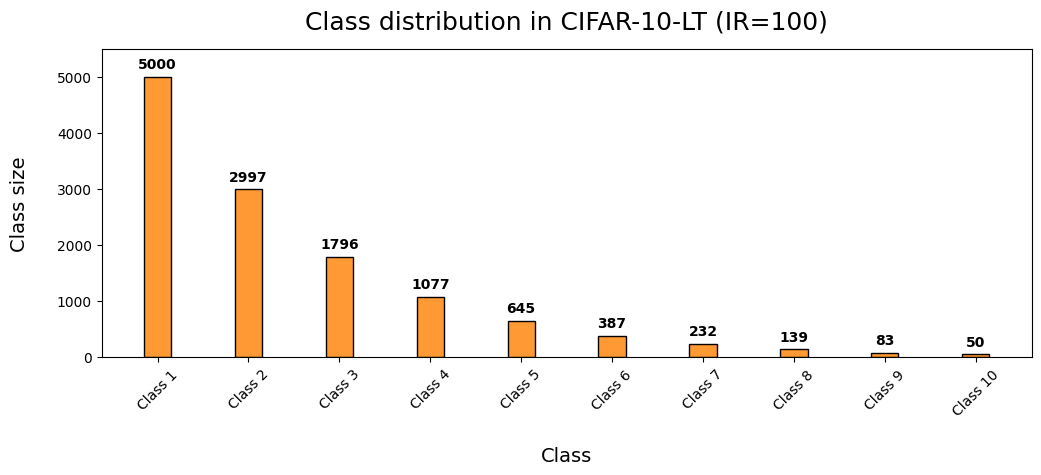

In [40]:
# Class distribution
f = plt.figure()
plt.xticks([x for x in range(len(class_count))], ["Class {}".format(i+1) for i in range(len(class_count))], rotation = 45)
plt.ylabel("Class size", fontsize=14, labelpad=20)
plt.xlabel("Class", fontsize=14, labelpad=20)
plt.ylim(0, 5500)
plt.title("Class distribution in CIFAR-10-LT (IR=100)", fontsize=18, pad=15)
plt.bar([x for x in range(len(class_count))], class_count, width=0.3, color="#ff9933", ec="k")
xlocs, xlabs = plt.xticks()
xlocs = [i for i in range(10)]
for i, v in enumerate(class_count):
    plt.text(xlocs[i], v + 1.5*1e2, str(v), horizontalalignment="center", fontdict={'weight': 'bold'})
f.set_figwidth(12)
f.set_figheight(4)

In [10]:
# Return network & file name
def getNetwork(version="BN"):

    if version=="BN":
        net = Wide_ResNet(depth, widen_factor, dropout, num_classes)
        file_name = 'wide-resnet-'+str(depth)+'x'+str(widen_factor)

    elif version=="DarBN":
        net = Wide_ResNet_DarBN(depth, widen_factor, dropout, num_classes)
        file_name = 'wide-resnet-darbn-' + str(depth) + 'x' + str(widen_factor)

    return net, file_name

### Training: Baseline model (160 epochs)

In [ ]:
%%capture cap

# Adapted from https://github.com/meliketoy/wide-resnet.pytorch, PyTorch implementation of
# Zagoruyko, S., & Komodakis, N. (2016). Wide residual networks. arXiv preprint arXiv:1605.07146.

# Model
print('\n[Phase 2] : Model setup')
if resume:
    # Load checkpoint
    print('| Resuming from checkpoint...')
    assert os.path.isdir('checkpoint'), 'Error: No checkpoint directory found!'
    _, file_name = getNetwork("BN")
    checkpoint = torch.load('./checkpoint/cifar10/wide-resnet-28x10_erm.t7')
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
else:
    print('| Building net type [' + net_type + ']...')
    net, file_name = getNetwork("BN")
    net.apply(conv_init)

if use_cuda:
    net.to(device)
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

# Training
def train(epoch, net):
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=cf.learning_rate(lr, epoch), momentum=0.9, weight_decay=2e-4)

    print('\n=> Training Epoch #%d, LR=%.5f' %(epoch, cf.learning_rate(lr, epoch)))
    for batch_idx, (inputs, targets) in enumerate(iter(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device) # GPU settings
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        loss.backward()  # Backward Propagation
        optimizer.step() # Optimizer update

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, start_epoch + num_epochs, batch_idx+1,
                    (len(trainset)//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()

def test(epoch, net, ext):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))

        if acc > best_acc:
            print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                    'net':net.module if use_cuda else net,
                    'acc':acc,
                    'epoch':epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            save_point = './checkpoint/'+dataset+os.sep
            if not os.path.isdir(save_point):
                os.mkdir(save_point)
            torch.save(state, save_point+file_name+ext+'.t7')
            best_acc = acc

print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + str(optim_type))

print("Best Accuracy: {}".format(best_acc))

elapsed_time = 0
for epoch in range(start_epoch, start_epoch+num_epochs):
    start_time = time.time()

    train(epoch, net)
    test(epoch, net, "_erm")

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(cf.get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))

torch.save(net.state_dict(), PATH + "\state_dicts\{}_{}_erm".format(dataset, str(imb_factor)))
torch.save(net, PATH + "\models\{}_{}_erm".format(dataset, str(imb_factor)))

### Training: Baseline model (additional 40 epochs with *learning rate decay*)

In [13]:
%%capture cap --no-stdout

# Oversampling - Class balanced loader
print('| Building net type [' + net_type + ']...')

net, file_name = getNetwork("BN")

pretrained_dict = torch.load(PATH + "/state_dicts/{}_{}_erm".format(dataset, str(imb_factor)))
new_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict()}
new_dict.update({k[7:]: v for k, v in pretrained_dict.items() if k not in net.state_dict()})
net.load_state_dict(new_dict)

if use_cuda:
    net.to(device)
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + str(optim_type))

elapsed_time = 0
for epoch in range(start_epoch_darbn, start_epoch_darbn+num_epochs_darbn):
    start_time = time.time()

    train(epoch, net)
    test(epoch, net, "_ERM_FULL")

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(cf.get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))

torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_ERM_FULL".format(dataset, str(imb_factor)))
torch.save(net, PATH + "/models/{}_{}_ERM_FULL".format(dataset, str(imb_factor)))

| Building net type [wide-resnet]...
| Wide-Resnet 28x10

[Phase 3] : Training model
| Training Epochs = 160
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #161, LR=0.00100
| Epoch [161/160] Iter[ 97/ 97]		Loss: 0.2877 Acc@1: 91.843%
| Validation Epoch #161			Loss: 0.7617 Acc@1: 77.67%
| Saving Best model...			Top1 = 77.67%
| Elapsed time : 0:02:03

=> Training Epoch #162, LR=0.00100
| Epoch [162/160] Iter[ 97/ 97]		Loss: 0.2443 Acc@1: 91.714%
| Validation Epoch #162			Loss: 0.8036 Acc@1: 77.28%
| Elapsed time : 0:03:52

=> Training Epoch #163, LR=0.00100
| Epoch [163/160] Iter[ 97/ 97]		Loss: 0.2616 Acc@1: 91.601%
| Validation Epoch #163			Loss: 0.7999 Acc@1: 76.75%
| Elapsed time : 0:05:42

=> Training Epoch #164, LR=0.00100
| Epoch [164/160] Iter[ 97/ 97]		Loss: 0.2616 Acc@1: 91.593%
| Validation Epoch #164			Loss: 0.7574 Acc@1: 77.25%
| Elapsed time : 0:07:31

=> Training Epoch #165, LR=0.00100
| Epoch [165/160] Iter[ 97/ 97]		Loss: 0.2121 Acc@1: 91.843%
| Valid

We choose as our *baseline model* the checkpoint with the higher *validation* (test) accuracy: $∼79.2\%$, *slightly smaller* than the one reported in the paper.

All the experiments are carried out starting from this **model checkpoint** and the same *early-stopping* technique is adopted to select each final model.

## OPeN: Oversampling with Pure Noise Images (Zada et al., 2022)

Define as $D := \bigcup_{i \in [C]} {(x_j, c_i)}_{j=1}^{n_i}$ a long-tailed imbalanced dataset containing $C$ classes $\{1, 2, \dots, C\}$, where each class $c_i$ contains $n_i$ training samples, with $n_1 \ge n_2 \ge \cdots \ge n_c$ and $n_1 \gg n_c$ (in our case $IR = \frac{n_1}{n_c} = 100$)

For each class $c_i$, the data are balanced by adding $n_i* = n_{max} − n_i$ **new training images** (where $n_{max} = n_1$ is the *largest* class), out of which $\delta \cdot n_i*$ are **pure noise images**, and $(1 - \delta) \cdot n_i*$ are real (oversampled) **natural images**. The *noise ratio* hyperparameter $\delta$ is set to be $\frac{1}{3}$ in all the authors experiments.

To handle the significant *distribution gap* between random noise images and natural images during training, a new normalization layer called **DAR-BN: Distribution-Aware Routing Batch Normalization** is introduced. **DAR-BN** normalizes the *noise activation maps* and the *natural activation maps* separately, using the *affine parameters* learned by the natural activation maps in order to scale and shift the noise activation maps.

At test time, since inputs are sampled only from the natural images domain, **DAR-BN** updates the batch statistics only using activation maps of natural images.

### OPeN Implementation

In [ ]:
%%capture cap --no-stdout

# Oversampling - Class balanced loader
print('| Building net type [' + net_type + ']...')

checkpoint = torch.load('./checkpoint/cifar10/wide-resnet-28x10_ERM_FULL.t7')
net = checkpoint['net']
torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_erm_full".format(dataset, str(imb_factor)))

net, file_name = getNetwork("DarBN")

pretrained_dict = torch.load(PATH + "/state_dicts/{}_{}_erm_full".format(dataset, str(imb_factor)))
new_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict()}
new_dict.update({k[7:]: v for k, v in pretrained_dict.items() if k not in net.state_dict()})
net.load_state_dict(new_dict)

if use_cuda:
    net.to(device)
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

class_count = np.bincount(trainset.targets)
sample_weights = [i/class_count[i] for i in trainset.targets]
num_samples = (max(class_count)*len(class_count)).item()

sampler_balanced = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
trainloader_balanced = DataLoader(trainset, sampler=sampler_balanced, batch_size=batch_size)

# From Appendix E in Zada et al., 2022
def oversampling_with_pure_noise_train_epoch(model, balanced_loader, criterion, delta, num_samples_per_class,
    dataset_mean, dataset_std, image_size, epoch):
    """Trains model for one epoch according to the OPeN scheme

        model : torch.nn.Module;
            Model to train
        balanced_loader: torch.utils.data.DataLoader
            A class balanced loader - samples each class with equal probability
        delta: float
            Hyper-parameter for OPeN (see description in paper)
        num_samples_per_class: torch.IntTensor
            Number of samples in each class in the original imbalanced dataset
        dataset_mean: torch.FloatTensor of size: (3)
            Dataset mean per color channel
        dataset_std: torch.FloatTensor of size: (3)
            Dataset standard deviation per color channel
        image_size: int
            Image size - Assumes squared images of size (image_size , image_size)
    """
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=cf.learning_rate(lr, epoch), momentum=0.9, weight_decay=2e-4)

    print('\n=> Training Epoch #%d, LR=%.5f' % (epoch, cf.learning_rate(lr, epoch)))
    for batch_idx, (images, targets) in enumerate(iter(balanced_loader)):
        # Compute representation ratio
        max_class_size = torch.max(num_samples_per_class)
        representation_ratio = num_samples_per_class[targets] / max_class_size
        # Compute probabilities to replace natural images with pure noise images
        noise_probs = (1 - representation_ratio) * delta
        # Sample indexes to replace with noise according to Bernoulli distribution
        noise_indices = torch.nonzero(torch.bernoulli(noise_probs)).view(-1)
        # Replace natural images with sampled pure noise images
        noise_images = sample_noise_images(image_size=image_size,
                    mean=dataset_mean, std=dataset_std, count=len(noise_indices))

        images[noise_indices] = noise_images
        # Create mask for noise images - later used by DAR-BN
        noise_mask = torch.zeros(images.size(0), dtype=torch.bool)
        noise_mask[noise_indices] = True
        images, targets, noise_mask = images.to(device), targets.to(device), noise_mask.to(device)
        # Train model
        images, targets = Variable(images), Variable(targets)
        outputs = model(images, noise_mask)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                         % (epoch, num_epochs, batch_idx + 1,
                            (num_samples // batch_size) + 1, loss.item(), 100. * correct / total))
        sys.stdout.flush()

def sample_noise_images(image_size, mean, std, count):
    """Samples pure noise images from the normal distribution N(mean,std)"""
    r = torch.normal(mean[0], std[0], size=(count, 1, image_size, image_size))
    g = torch.normal(mean[1], std[1], size=(count, 1, image_size, image_size))
    b = torch.normal(mean[2], std[2], size=(count, 1, image_size, image_size))
    pure_noise_images = torch.cat((r, g, b), 1)

    return pure_noise_images

def test_darbn(epoch, net, save_name):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(testloader):
            images, targets = Variable(images), Variable(targets)
            noise_mask = torch.zeros(images.size(0), dtype=torch.bool)
            images, targets, noise_mask = images.to(device), targets.to(device), noise_mask.to(device)
            outputs = net(images, noise_mask)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))

        if acc > best_acc:
            print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                    'net':net.module if use_cuda else net,
                    'acc':acc,
                    'epoch':epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            save_point = './checkpoint/'+dataset+os.sep
            if not os.path.isdir(save_point):
                os.mkdir(save_point)
            torch.save(state, save_point+save_name+'.t7')
            best_acc = acc

print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + str(optim_type))

elapsed_time = 0
for epoch in range(start_epoch_darbn, start_epoch_darbn+num_epochs_darbn):
    start_time = time.time()

    oversampling_with_pure_noise_train_epoch(net, trainloader_balanced, criterion, delta, torch.from_numpy(class_count),
    mean_dict[dataset+"_"+str(imb_factor)], std_dict[dataset+"_"+str(imb_factor)], 32, epoch)
    test_darbn(epoch, net, "OPeN_ERM_FULL")

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(cf.get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))

torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_OPeN_ERM_FULL".format(dataset, str(imb_factor)))
torch.save(net, PATH + "/models/{}_{}_OPeN_ERM_FULL".format(dataset, str(imb_factor)))

| Building net type [wide-resnet]...
| Wide-Resnet 28x10

[Phase 3] : Training model
| Training Epochs = 160
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #161, LR=0.00100
| Epoch [161/160] Iter[391/391]		Loss: 1.5124 Acc@1: 55.464%
| Validation Epoch #161			Loss: 0.5235 Acc@1: 82.99%
| Saving Best model...			Top1 = 82.99%
| Elapsed time : 0:06:55

=> Training Epoch #162, LR=0.00100
| Epoch [162/160] Iter[391/391]		Loss: 1.4598 Acc@1: 66.056%
| Validation Epoch #162			Loss: 0.4278 Acc@1: 83.78%
| Saving Best model...			Top1 = 83.78%
| Elapsed time : 0:13:35

=> Training Epoch #163, LR=0.00100
| Epoch [163/160] Iter[391/391]		Loss: 1.2827 Acc@1: 67.652%
| Validation Epoch #163			Loss: 0.4432 Acc@1: 83.41%
| Elapsed time : 0:20:16

=> Training Epoch #164, LR=0.00100
| Epoch [164/160] Iter[391/391]		Loss: 1.1597 Acc@1: 67.828%
| Validation Epoch #164			Loss: 0.4450 Acc@1: 83.22%
| Elapsed time : 0:26:56

=> Training Epoch #165, LR=0.00100
| Epoch [165/160] Iter[391/39

The **Top-1 Test Accuracy** reached by the model is $∼83.8\%$, again *slightly smaller* than the $84.6\%$ of the paper; in addition, the accuracy peaks after two or three epochs, dropping sharply afterwards (a behavior that we observed in every other experiment performed). While the cause of the gap in *absolute* performance and of this *earlier emergence* of the overfitting phenomenon with respect to what the authors claim might be attributed to a different, lighter preprocessing on our side (as we stated before), the accuracy is still *significantly* higher than the ones listed in the paper, achieved by different pre-existing methods.

# Ablation Study - Are *pure gaussian noise* images the key ingredient?

The authors state that the **OPeN** method achieves improvement in **generalization on minority classes** since oversampling with *pure noise* images provides:

1) a **regularization effect** on the training process by adding *stochasticity* in the gradient components magnitude and direction
2) the ability to **generate** new random noise training samples **without being limited** by the number and variety of existing samples in the data

They also hypothesize that since noise inputs are completely random and **class independent**, and they carry de facto **no information** except for the class labels assigned to them, the
network learns to implicitly encode the *prior class probabilities* and correct its predictions accordingly.

**Our idea**: come up with a **class dependent** data generating process, producing images that would meet both the **OPeN** properties achieved by the pure noise inputs, while still carrying information **useful for the purpose of classification**.

## Stable Diffusion (Rombach et al., 2022)

**Stable Diffusion** is a text-to-image latent diffusion model created by the researchers and engineers from CompVis, Stability AI and LAION.

Diffusion models are generative models trained to **denoise** *random Gaussian noise* step by step, to get to a sample of interest, such as an image; they have shown to achieve *State-Of-The-Art* results for many image-generating tasks.

We use the pre-trained **Stable Diffusion** model (checkpoint *v1.4*, downloaded from the *HuggingFace Hub*) as our **class dependent** data generating mechanism, providing as textual input **prompt** only the official **labels** of the classes.

## OSeD: Oversampling with Stable Diffusion Images

We propose **OSeD**, a variation of the **OPeN** method using the **Stable Diffusion** model to generate **out-of-distribution**, **class dependent** images to replace natural training samples. Whenever a training natural image should be *substituted*, it is replaced by the output of the **Stable Diffusion** model, which is fed with the **ground truth label** of the sample.

In order to match the size of the samples in CIFAR-10, we need the **Stable Diffusion** model to generate 32x32 images. However, we soon found out that the **output size** hyperparameter influenced the quality of the denoising process: keeping all the other settings unchanged, by *decreasing* the **dimension** the outputs moved from **clearly depicting the input prompt** to **closely resembling random noise**!

In [11]:
device = "cuda"
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16
).to(device)

img_to_tensor = transforms.PILToTensor()

# edit StableDiffusionSafetyChecker class so that, when called, it just returns the images and an array of True values
safety_checker.StableDiffusionSafetyChecker.forward = sc

prompt = "bird"

In [18]:
%%capture

size_list = [32]+[64*i for i in range(1,9)]

img_list = []
for i in range(len(size_list)):
    img_list.append(pipe(prompt=prompt, height=size_list[i], width=size_list[i], num_inference_steps=40, guidance_scale=7.5, generator=torch.Generator("cuda").manual_seed(1024)).images[0])

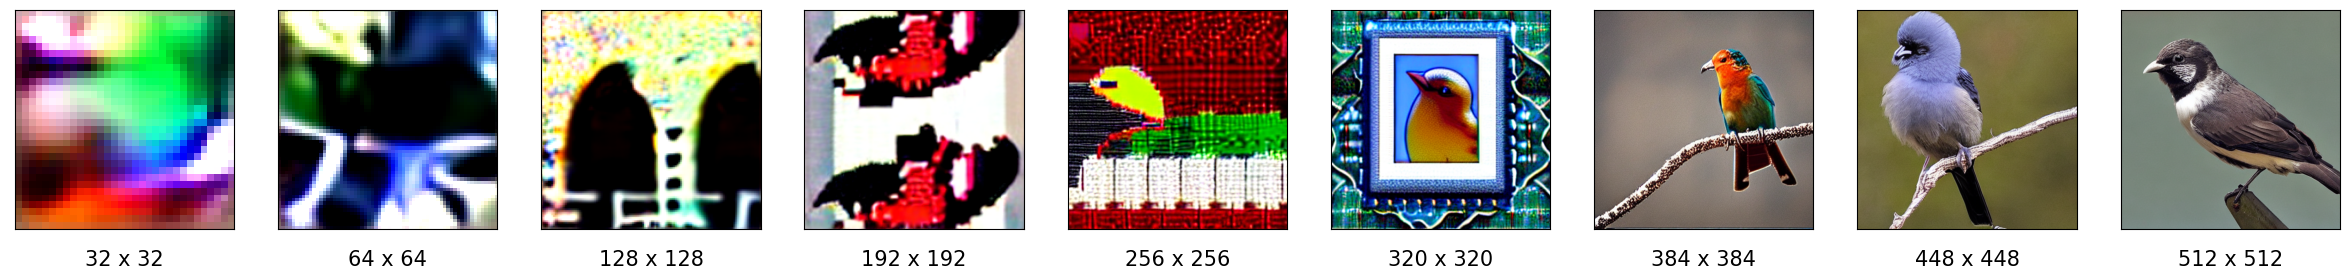

In [21]:
fig, axs = plt.subplots(1,9, figsize=(30, 40))

for i in range(len(axs)):
    axs[i].set_xticks([], minor=True)
    axs[i].set_xticks([])
    axs[i].set_yticks([], minor=True)
    axs[i].set_yticks([])
    axs[i].set_xlabel(str(size_list[i])+" x "+str(size_list[i]), labelpad = 15, fontdict = {"size": 15})

for i in range(len(axs)):
    axs[i].imshow(img_list[i])

We believe that the reason behind a similar behavior has to be found in the structure of the **U-Net** component of the **Stable Diffusion** model: made up of an *encoder* part and a *decoder* part comprised of ResNet blocks, it compresses an image representation, via sequential downsampling steps halving the image size by 2, into a lower resolution one before bringing it back to the original size, denoising it in the process. We suppose that, if the input image is **too small**, the intermediate resolution would be **way too tiny** for the denoising procedure to work properly.

We test our hypothesis by running the **Stable Diffusion** model with the same **random seed**, while increasing the **number of inference (denoising) steps** hyperparameter, to generate both a 32x32 and a 256x256 image: the quality of the *larger* image **improves significantly**, whereas almost **no difference is noticeable** for the *smaller* one.

In [12]:
%%capture

num_steps = [40, 100, 200]

img_list_1 = []
for i in range(3):
    img_list_1.append(pipe(prompt=prompt, height=32, width=32, num_inference_steps=num_steps[i], guidance_scale=7.5, generator=torch.Generator("cuda").manual_seed(1024)).images[0])

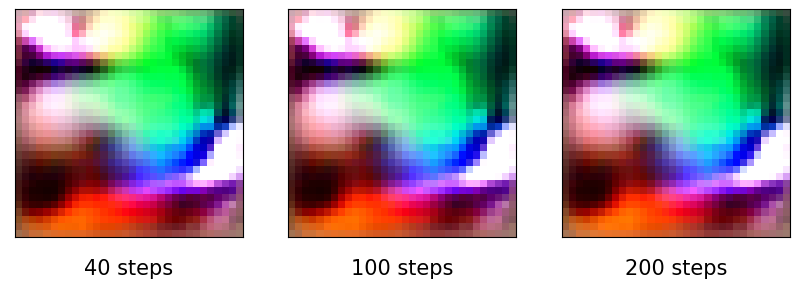

In [16]:
# 32x32 image
fig, axs = plt.subplots(1,3, figsize=(10, 20))

for i in range(len(axs)):
    axs[i].set_xticks([], minor=True)
    axs[i].set_xticks([])
    axs[i].set_yticks([], minor=True)
    axs[i].set_yticks([])
    axs[i].set_xlabel(str(num_steps[i])+ " steps", labelpad = 15, fontdict = {"size": 15})

for i in range(len(axs)):
    axs[i].imshow(img_list_1[i])

In [23]:
%%capture

img_list_2 = []
for i in range(3):
    img_list_2.append(pipe(prompt=prompt, height=256, width=256, num_inference_steps=num_steps[i], guidance_scale=7.5, generator=torch.Generator("cuda").manual_seed(1024)).images[0])

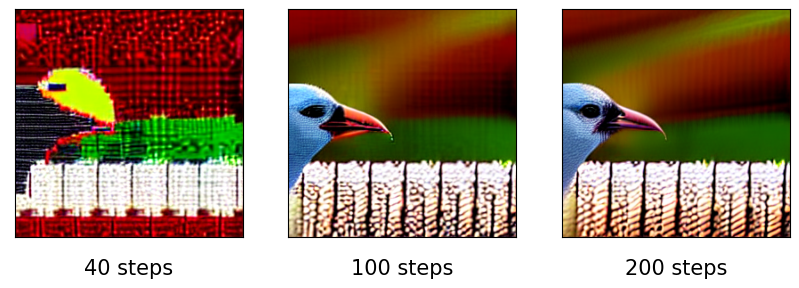

In [24]:
# 256x256 image
fig, axs = plt.subplots(1,3, figsize=(10, 20))

for i in range(len(axs)):
    axs[i].set_xticks([], minor=True)
    axs[i].set_xticks([])
    axs[i].set_yticks([], minor=True)
    axs[i].set_yticks([])
    axs[i].set_xlabel(str(num_steps[i])+ " steps", labelpad = 15, fontdict = {"size": 15})

for i in range(len(axs)):
    axs[i].imshow(img_list_2[i])

In this perspective, the **output size** might be seen as a hyperparameter controlling the **amount of class-related information conveyed by the image** (**input prompt representation** VS **random gaussian noise**).

We therefore set up three different variants of the **OSeD** method, with **output size** = 32x32, 192x192, 512x512 respectively (resizing the larger outputs to 32x32 resolution via *standard scaling algorithms* before substituting them). The **num_inference_steps** is set to $40$ in all the variants.

Due to the large *computational* and *memory* complexity required by the **Stable Diffusion** algorithm, we were able to generate **new training images** at running time *only* for the smallest resolution; for both the higher ones, we **pre-generated** for each class label an amount of images equals to the one needed (on average) in an epoch and then we **sampled** them at training time.

## OSeD: Oversampling with Stable Diffusion Images (32x32)

In [17]:
classes = np.array(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
prompt = np.repeat(classes[1:], 10).tolist()

In [ ]:
%%capture

device = "cuda"
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16
).to(device)

stable_images = pipe(prompt=prompt, height=32, width=32, num_inference_steps=40, guidance_scale=7.5).images

img_to_tensor = transforms.PILToTensor()
imgs_plot = torch.stack([img_to_tensor(image).type(torch.FloatTensor) / 255.0 for image in stable_images])

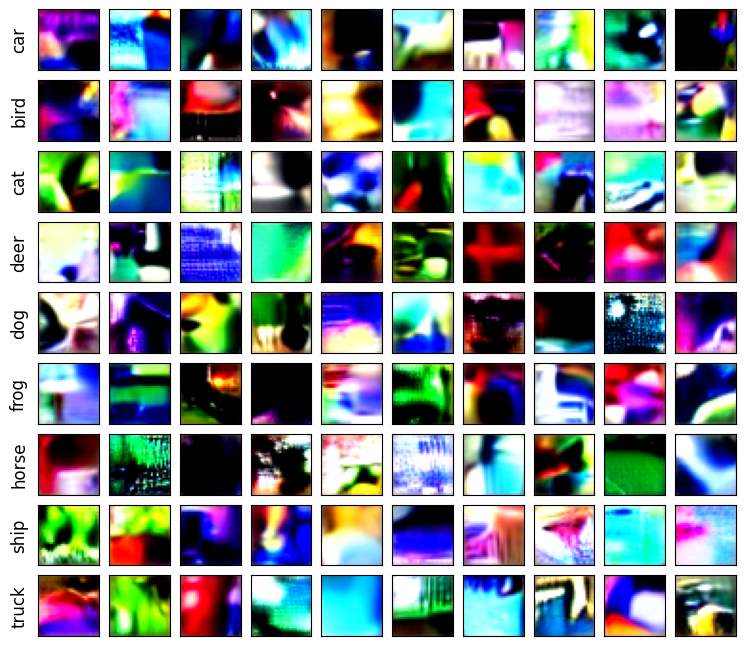

In [23]:
# Some examples of 32x32 SD images for the different classes (except the larger class: Airplane)

fig = plt.figure(figsize=(9, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(9, 10), axes_pad=0.1)

for ax, im, label in zip(grid, imgs_plot, prompt):
    ax.set_xticks([], minor=True)
    ax.set_xticks([])
    ax.set_yticks([], minor=True)
    ax.set_yticks([])
    ax.set_ylabel(label, labelpad = 7.5, fontdict = {"size": 12})
    ax.imshow(im.permute(1, 2, 0))

plt.show()

In [ ]:
%%capture cap --no-stdout

# Oversampling - Class balanced loader
print('| Building net type [' + net_type + ']...')

checkpoint = torch.load('./checkpoint/cifar10/wide-resnet-28x10_ERM_FULL.t7')
net = checkpoint['net']
torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_full".format(dataset, str(imb_factor)))

net, file_name = getNetwork("DarBN")

pretrained_dict = torch.load(PATH + "/state_dicts/{}_{}_full".format(dataset, str(imb_factor)))
new_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict()}
new_dict.update({k[7:]: v for k, v in pretrained_dict.items() if k not in net.state_dict()})
net.load_state_dict(new_dict)

if use_cuda:
    net.to(device)
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

safety_checker.StableDiffusionSafetyChecker.forward = sc

class_count = np.bincount(trainset.targets)
sample_weights = [i/class_count[i] for i in trainset.targets]
num_samples = (max(class_count)*len(class_count)).item()

sampler_balanced = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
trainloader_balanced = DataLoader(trainset, sampler=sampler_balanced, batch_size=batch_size)

def OSeD(net, balanced_loader, criterion, delta, num_samples_per_class, image_size, epoch, pipe):

    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=cf.learning_rate(lr, epoch), momentum=0.9, weight_decay=2e-4)

    print('\n=> Training Epoch #%d, LR=%.5f' % (epoch, cf.learning_rate(lr, epoch)))
    for batch_idx, (images, targets) in enumerate(iter(balanced_loader)):
        # Compute representation ratio
        max_class_size = torch.max(num_samples_per_class)
        representation_ratio = num_samples_per_class[targets] / max_class_size
        # Compute probabilities to replace natural images with pure noise images
        noise_probs = (1 - representation_ratio) * delta
        # Sample indexes to replace with noise according to Bernoulli distribution
        noise_indices = torch.nonzero(torch.bernoulli(noise_probs)).view(-1)

        classes = np.array(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

        prompt = classes[targets[noise_indices].numpy()].tolist()

        # Replace natural images with sampled pure noise images
        stable_images = pipe(prompt=prompt, height=image_size, width=image_size, num_inference_steps=40, guidance_scale=7.5).images

        img_to_tensor = transforms.PILToTensor()
        images[noise_indices] = torch.stack([img_to_tensor(image).type(torch.FloatTensor) / 255.0 for image in stable_images])

        # Create mask for noise images - later used by DAR-BN
        noise_mask = torch.zeros(images.size(0), dtype=torch.bool)
        noise_mask[noise_indices] = True
        images, targets, noise_mask = images.to(device), targets.to(device), noise_mask.to(device)
        del stable_images
        # Train model
        images, targets = Variable(images), Variable(targets)
        outputs = net(images, noise_mask)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                         % (epoch, num_epochs + num_epochs_darbn, batch_idx + 1,
                            (num_samples // batch_size) + 1, loss.item(), 100. * correct / total))
        sys.stdout.flush()

print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + str(optim_type))

elapsed_time = 0
for epoch in range(start_epoch_darbn, start_epoch_darbn+num_epochs_darbn):
    start_time = time.time()

    pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16
    ).to(device)

    OSeD(net, trainloader_balanced, criterion, delta, torch.from_numpy(class_count), 32, epoch, pipe)
    test_darbn(epoch, net, "OSeD_ERM_FULL_32")

    del pipe

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(cf.get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))

torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_OSeD_ERM_FULL_32".format(dataset, str(imb_factor)))
torch.save(net, PATH + "/models/{}_{}_OSeD_ERM_FULL_32".format(dataset, str(imb_factor)))

| Building net type [wide-resnet]...
| Wide-Resnet 28x10

[Phase 3] : Training model
| Training Epochs = 160
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #161, LR=0.00100
| Epoch [161/200] Iter[391/391]		Loss: 0.8233 Acc@1: 55.090%
| Validation Epoch #161			Loss: 0.3783 Acc@1: 82.76%
| Saving Best model...			Top1 = 82.76%
| Elapsed time : 0:31:29

=> Training Epoch #162, LR=0.00100
| Epoch [162/200] Iter[391/391]		Loss: 1.7781 Acc@1: 66.426%
| Validation Epoch #162			Loss: 0.3716 Acc@1: 83.70%
| Saving Best model...			Top1 = 83.70%
| Elapsed time : 0:59:31

=> Training Epoch #163, LR=0.00100
| Epoch [163/200] Iter[391/391]		Loss: 0.9864 Acc@1: 67.282%
| Validation Epoch #163			Loss: 0.4044 Acc@1: 83.88%
| Saving Best model...			Top1 = 83.88%
| Elapsed time : 1:27:29

=> Training Epoch #164, LR=0.00100
| Epoch [164/200] Iter[391/391]		Loss: 1.3245 Acc@1: 67.842%
| Validation Epoch #164			Loss: 0.4438 Acc@1: 83.03%
| Elapsed time : 1:55:23

=> Training Epoch #165, L

## OSeD: Oversampling with Stable Diffusion Images (192x192)

In [29]:
SD_PATH = PATH + "/SD_Images"

classes = np.array(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
representation_ratio = np.array([i/5000 for i in class_count])
noise_images = (1 - representation_ratio) * (1/3)
num_images = [round(x) for x in noise_images*100]
img_samples = {classes[i]: num_images[i]*25 for i in range(len(num_images))}

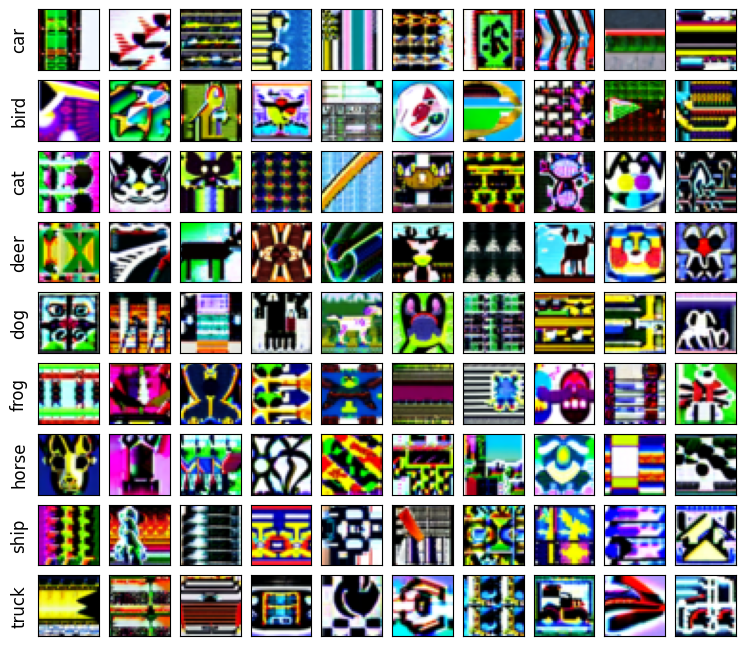

In [30]:
# Some examples of 192x192 SD images for the different classes (except the larger class: Airplane)

prompt = np.repeat(classes[1:], 10)
sources = ["A", "B"]
img_names = [SD_PATH + "/" + x + random.choice(sources) + str(random.randint(1, img_samples[x])) + ".png" for x in prompt]
stable_images = [Image.open(img).convert("RGB") for img in img_names]

img_to_tensor = transforms.PILToTensor()
imgs_plot = torch.stack([img_to_tensor(image).type(torch.FloatTensor) / 255.0 for image in stable_images])

fig = plt.figure(figsize=(9, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(9, 10), axes_pad=0.1)

for ax, im, label in zip(grid, imgs_plot, prompt):

    ax.set_xticks([], minor=True)
    ax.set_xticks([])
    ax.set_yticks([], minor=True)
    ax.set_yticks([])
    ax.set_ylabel(label, labelpad = 7.5, fontdict = {"size": 12})
    ax.imshow(im.permute(1, 2, 0))

plt.show()

In [8]:
%%capture cap --no-stdout

# Oversampling - Class balanced loader
print('| Building net type [' + net_type + ']...')

checkpoint = torch.load('./checkpoint/cifar10/wide-resnet-28x10_ERM_FULL.t7')
net = checkpoint['net']
torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_full".format(dataset, str(imb_factor)))

net, file_name = getNetwork("DarBN")

pretrained_dict = torch.load(PATH + "/state_dicts/{}_{}_full".format(dataset, str(imb_factor)))
new_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict()}
new_dict.update({k[7:]: v for k, v in pretrained_dict.items() if k not in net.state_dict()})
net.load_state_dict(new_dict)

if use_cuda:
    net.to(device)
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

safety_checker.StableDiffusionSafetyChecker.forward = sc

class_count = np.bincount(trainset.targets)
sample_weights = [i/class_count[i] for i in trainset.targets]
num_samples = (max(class_count)*len(class_count)).item()

sampler_balanced = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
trainloader_balanced = DataLoader(trainset, sampler=sampler_balanced, batch_size=batch_size)

def OSeD(net, balanced_loader, criterion, delta, num_samples_per_class, epoch):

    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=cf.learning_rate(lr, epoch), momentum=0.9, weight_decay=2e-4)

    print('\n=> Training Epoch #%d, LR=%.5f' % (epoch, cf.learning_rate(lr, epoch)))
    for batch_idx, (images, targets) in enumerate(iter(balanced_loader)):
        # Compute representation ratio
        max_class_size = torch.max(num_samples_per_class)
        representation_ratio = num_samples_per_class[targets] / max_class_size
        # Compute probabilities to replace natural images with pure noise images
        noise_probs = (1 - representation_ratio) * delta
        # Sample indexes to replace with noise according to Bernoulli distribution
        noise_indices = torch.nonzero(torch.bernoulli(noise_probs)).view(-1)

        prompt = classes[targets[noise_indices].numpy()].tolist()
        sources = ["A", "B"]
        img_names = [SD_PATH + "/" + x + random.choice(sources) + str(random.randint(1, img_samples[x])) + ".png" for x in prompt]

        # Replace natural images with sampled pure noise images
        stable_images = [Image.open(img).convert("RGB") for img in img_names]

        img_to_tensor = transforms.PILToTensor()
        images[noise_indices] = torch.stack([img_to_tensor(image).type(torch.FloatTensor) / 255.0 for image in stable_images])

        # Create mask for noise images - later used by DAR-BN
        noise_mask = torch.zeros(images.size(0), dtype=torch.bool)
        noise_mask[noise_indices] = True
        images, targets, noise_mask = images.to(device), targets.to(device), noise_mask.to(device)
        del stable_images
        # Train model
        images, targets = Variable(images), Variable(targets)
        outputs = net(images, noise_mask)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                         % (epoch, num_epochs + num_epochs_darbn, batch_idx + 1,
                            (num_samples // batch_size) + 1, loss.item(), 100. * correct / total))
        sys.stdout.flush()

print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + str(optim_type))

elapsed_time = 0
for epoch in range(start_epoch_darbn, start_epoch_darbn+num_epochs_darbn):
    start_time = time.time()

    pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16
    ).to(device)

    OSeD(net, trainloader_balanced, criterion, delta, torch.from_numpy(class_count), epoch)
    test_darbn(epoch, net, "OSeD_ERM_FULL_192")

    del pipe

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(cf.get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))

torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_OSeD_ERM_FULL_192".format(dataset, str(imb_factor)))
torch.save(net, PATH + "/models/{}_{}_OSeD_ERM_FULL_192".format(dataset, str(imb_factor)))

| Building net type [wide-resnet]...
| Wide-Resnet 28x10

[Phase 3] : Training model
| Training Epochs = 160
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #161, LR=0.00100
| Epoch [161/200] Iter[391/391]		Loss: 1.6555 Acc@1: 56.810%
| Validation Epoch #161			Loss: 0.4490 Acc@1: 83.40%
| Saving Best model...			Top1 = 83.40%
| Elapsed time : 0:08:39

=> Training Epoch #162, LR=0.00100
| Epoch [162/200] Iter[391/391]		Loss: 1.2187 Acc@1: 68.214%
| Validation Epoch #162			Loss: 0.3883 Acc@1: 83.74%
| Saving Best model...			Top1 = 83.74%
| Elapsed time : 0:17:02

=> Training Epoch #163, LR=0.00100
| Epoch [163/200] Iter[391/391]		Loss: 1.2035 Acc@1: 69.164%
| Validation Epoch #163			Loss: 0.4060 Acc@1: 83.52%
| Elapsed time : 0:25:27

=> Training Epoch #164, LR=0.00100
| Epoch [164/200] Iter[391/391]		Loss: 1.4573 Acc@1: 69.778%
| Validation Epoch #164			Loss: 0.4336 Acc@1: 82.81%
| Elapsed time : 0:33:49

=> Training Epoch #165, LR=0.00100


## OSeD: Oversampling with Stable Diffusion Images (512x512)

In [33]:
SD_PATH = PATH + "/SD_Images_512"

classes = np.array(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
representation_ratio = np.array([i/5000 for i in class_count])
noise_images = (1 - representation_ratio) * (1/3)
num_images = [round(x) for x in noise_images*100]
img_samples = {classes[i]: num_images[i]*8 for i in range(len(num_images))}

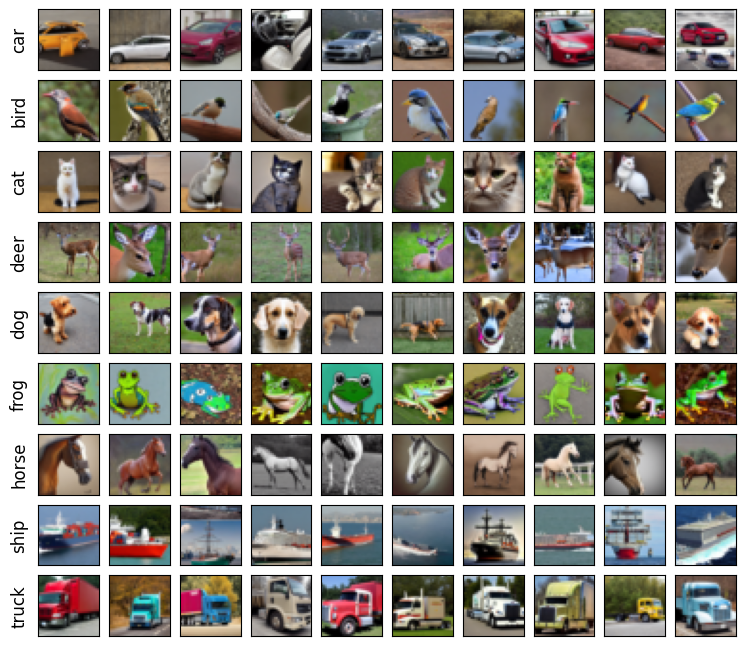

In [34]:
# Some examples of 512x512 SD images for the different classes (except the larger class: Airplane)

prompt = np.repeat(classes[1:], 10)
sources = ["A", "B", "C", "D", "E", "F"]
img_names = [SD_PATH + "/" + x + "512" + random.choice(sources) + str(random.randint(1, img_samples[x])) + ".png" for x in prompt]
stable_images = [Image.open(img).convert("RGB") for img in img_names]

img_to_tensor = transforms.PILToTensor()
imgs_plot = torch.stack([img_to_tensor(image).type(torch.FloatTensor) / 255.0 for image in stable_images])

fig = plt.figure(figsize=(9, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(9, 10), axes_pad=0.1)

for ax, im, label in zip(grid, imgs_plot, prompt):

    ax.set_xticks([], minor=True)
    ax.set_xticks([])
    ax.set_yticks([], minor=True)
    ax.set_yticks([])
    ax.set_ylabel(label, labelpad = 7.5, fontdict = {"size": 12})
    ax.imshow(im.permute(1, 2, 0))

plt.show()

In [9]:
%%capture cap --no-stdout

# Oversampling - Class balanced loader
print('| Building net type [' + net_type + ']...')

checkpoint = torch.load('./checkpoint/cifar10/wide-resnet-28x10_ERM_FULL.t7')
net = checkpoint['net']
torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_full".format(dataset, str(imb_factor)))

net, file_name = getNetwork("DarBN")

pretrained_dict = torch.load(PATH + "/state_dicts/{}_{}_full".format(dataset, str(imb_factor)))
new_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict()}
new_dict.update({k[7:]: v for k, v in pretrained_dict.items() if k not in net.state_dict()})
net.load_state_dict(new_dict)

if use_cuda:
    net.to(device)
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

safety_checker.StableDiffusionSafetyChecker.forward = sc

class_count = np.bincount(trainset.targets)
sample_weights = [i/class_count[i] for i in trainset.targets]
num_samples = (max(class_count)*len(class_count)).item()

sampler_balanced = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
trainloader_balanced = DataLoader(trainset, sampler=sampler_balanced, batch_size=batch_size)

def OSeD(net, balanced_loader, criterion, delta, num_samples_per_class, epoch):

    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=cf.learning_rate(lr, epoch), momentum=0.9, weight_decay=2e-4)

    print('\n=> Training Epoch #%d, LR=%.5f' % (epoch, cf.learning_rate(lr, epoch)))
    for batch_idx, (images, targets) in enumerate(iter(balanced_loader)):
        # Compute representation ratio
        max_class_size = torch.max(num_samples_per_class)
        representation_ratio = num_samples_per_class[targets] / max_class_size
        # Compute probabilities to replace natural images with pure noise images
        noise_probs = (1 - representation_ratio) * delta
        # Sample indexes to replace with noise according to Bernoulli distribution
        noise_indices = torch.nonzero(torch.bernoulli(noise_probs)).view(-1)

        prompt = classes[targets[noise_indices].numpy()].tolist()
        sources = ["A", "B", "C", "D", "E", "F"]
        img_names = [SD_PATH + "/" + x + "512" + random.choice(sources) + str(random.randint(1, img_samples[x])) + ".png" for x in prompt]

        # Replace natural images with sampled pure noise images
        stable_images = [Image.open(img).convert("RGB") for img in img_names]

        img_to_tensor = transforms.PILToTensor()
        images[noise_indices] = torch.stack([img_to_tensor(image).type(torch.FloatTensor) / 255.0 for image in stable_images])

        # Create mask for noise images - later used by DAR-BN
        noise_mask = torch.zeros(images.size(0), dtype=torch.bool)
        noise_mask[noise_indices] = True
        images, targets, noise_mask = images.to(device), targets.to(device), noise_mask.to(device)
        del stable_images
        # Train model
        images, targets = Variable(images), Variable(targets)
        outputs = net(images, noise_mask)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                         % (epoch, num_epochs + num_epochs_darbn, batch_idx + 1,
                            (num_samples // batch_size) + 1, loss.item(), 100. * correct / total))
        sys.stdout.flush()

print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + str(optim_type))

elapsed_time = 0
for epoch in range(start_epoch_darbn, start_epoch_darbn+num_epochs_darbn):
    start_time = time.time()

    pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16
    ).to(device)

    OSeD(net, trainloader_balanced, criterion, delta, torch.from_numpy(class_count), epoch)
    test_darbn(epoch, net, "OSeD_ERM_FULL_512")

    del pipe

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(cf.get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))

torch.save(net.state_dict(), PATH + "/state_dicts/{}_{}_OSeD_ERM_FULL_512".format(dataset, str(imb_factor)))
torch.save(net, PATH + "/models/{}_{}_OSeD_ERM_FULL_512".format(dataset, str(imb_factor)))

| Building net type [wide-resnet]...
| Wide-Resnet 28x10

[Phase 3] : Training model
| Training Epochs = 160
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #161, LR=0.00100
| Epoch [161/200] Iter[391/391]		Loss: 0.4382 Acc@1: 71.916%
| Validation Epoch #161			Loss: 0.4628 Acc@1: 82.84%
| Saving Best model...			Top1 = 82.84%
| Elapsed time : 0:13:05

=> Training Epoch #162, LR=0.00100
| Epoch [162/200] Iter[391/391]		Loss: 0.5131 Acc@1: 86.586%
| Validation Epoch #162			Loss: 0.4456 Acc@1: 84.05%
| Saving Best model...			Top1 = 84.05%
| Elapsed time : 0:27:50

=> Training Epoch #163, LR=0.00100
| Epoch [163/200] Iter[391/391]		Loss: 0.4867 Acc@1: 88.270%
| Validation Epoch #163			Loss: 0.5011 Acc@1: 83.62%
| Elapsed time : 0:42:12

=> Training Epoch #164, LR=0.00100
| Epoch [164/200] Iter[391/391]		Loss: 0.3368 Acc@1: 88.554%
| Validation Epoch #164			Loss: 0.4449 Acc@1: 83.25%
| Elapsed time : 0:50:28

=> Training Epoch #165, LR=0.00100
| Epoch [165/200] Iter[391/39

# Experimental results

In [26]:
# Visualization
values = {"acc_per_class": {}, "best_acc": {}}

def test_only(net, values):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    acc_per_class = torch.zeros(num_classes).long().to(device)
    correct_per_class = torch.zeros(num_classes).long().to(device)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)

            arr = predicted.eq(targets.data).long().to(device)

            acc_per_class = acc_per_class.scatter_add(0, targets, arr)
            correct_per_class = correct_per_class.scatter_add(0, targets, torch.Tensor([1 for x in range(len(arr))]).long().to(device))
            correct += predicted.eq(targets.data).cpu().sum()

        values["best_acc"]["ERM"] = 100. * correct/total
        values["acc_per_class"]["ERM"] = [(acc_per_class[i]+acc_per_class[i+1])/(correct_per_class[i]+correct_per_class[i+1]) for i in range(0, num_classes, 2)]

def test_darbn_only(net, label, values):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    acc_per_class = torch.zeros(num_classes).long().to(device)
    correct_per_class = torch.zeros(num_classes).long().to(device)
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(testloader):
            noise_mask = torch.zeros(images.size(0), dtype=torch.bool)
            images, targets, noise_mask = images.to(device), targets.to(device), noise_mask.to(device)
            outputs = net(images, noise_mask)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.to(device)
            total += targets.size(0)

            arr = predicted.eq(targets.data).long().to(device)

            acc_per_class = acc_per_class.scatter_add(0, targets, arr)
            correct_per_class = correct_per_class.scatter_add(0, targets, torch.Tensor([1 for x in range(len(arr))]).long().to(device))
            correct += predicted.eq(targets.data).cpu().sum()

        values["best_acc"][label] = 100. * correct/total
        values["acc_per_class"][label] = [(acc_per_class[i]+acc_per_class[i+1])/(correct_per_class[i]+correct_per_class[i+1]) for i in range(0, num_classes, 2)]

In [ ]:
# ERM
checkpoint = torch.load('./checkpoint/cifar10/wide-resnet-28x10_ERM_FULL.t7')
net = checkpoint['net']
test_only(net, values)

# OPeN
checkpoint = torch.load('./checkpoint/cifar10/OPeN_ERM_FULL.t7')
net = checkpoint['net']
test_darbn_only(net, "OPeN", values)

# OSeD 32
checkpoint = torch.load('./checkpoint/cifar10/OSeD_ERM_FULL.t7')
net = checkpoint['net']
test_darbn_only(net, "OSeD 32", values)

# OSeD 192
checkpoint = torch.load('./checkpoint/cifar10/OSeD_ERM_FULL_192.t7')
net = checkpoint['net']
test_darbn_only(net, "OSeD 192", values)

# OSeD 512
checkpoint = torch.load('./checkpoint/cifar10/OSeD_ERM_FULL_512.t7')
net = checkpoint['net']
test_darbn_only(net, "OSeD 512", values)

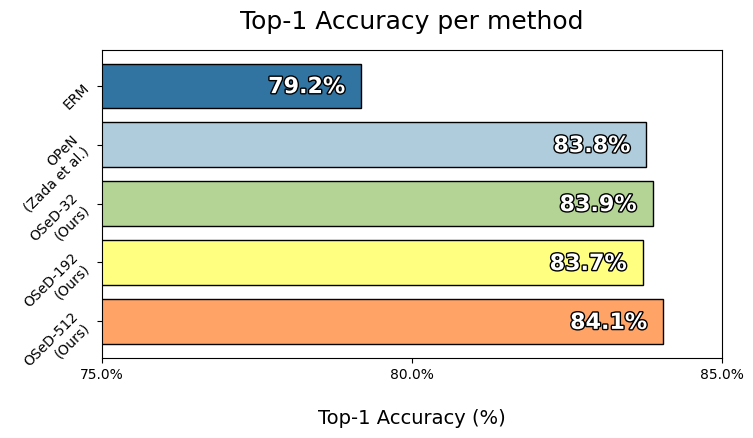

In [41]:
# Top-1 Accuracy per method
f = plt.figure()
plt.yticks([x for x in np.arange(0, 1.0, 0.2)], ["OSeD-512\n(Ours)", "OSeD-192\n(Ours)","OSeD-32\n(Ours)", "OPeN\n(Zada et al.)", "ERM"], rotation = 45)
plt.xticks([y for y in [i/10 for i in np.arange(7.5, 9, 0.5)]], [str(y*10)+"%" for y in np.arange(7.5, 9, 0.5)])
plt.xlabel("Top-1 Accuracy (%)", fontsize=14, labelpad=20)
plt.xlim(0.75, 0.85)
plt.title("Top-1 Accuracy per method", fontsize=18, pad=15)
x = [x for x in np.arange(0, 1.0, 0.2)]
y = [round(values["best_acc"][x].item(),3)/100 for x in ["ERM", "OPeN", "OSeD 32", "OSeD 192", "OSeD 512"]][::-1]
plt.barh(x, y, height=0.15, color=["#ffa366", "#ffff80", "#b3d495", "#aeccdb", "#3274a1"], ec="k")
xlocs, xlabs = plt.xticks()
xlocs=[x for x in np.arange(0, 1.0, 0.2)]
for i, v in enumerate(y):
    plt.text(v-0.015, xlocs[i]-0.005, str(round(v*100+1e-10,1))+"%", verticalalignment="center", fontdict={'color': 'white','weight': 'bold','size': 16, "path_effects": [pe.withStroke(linewidth=2, foreground="black")]})
f.set_figwidth(8)
f.set_figheight(4)

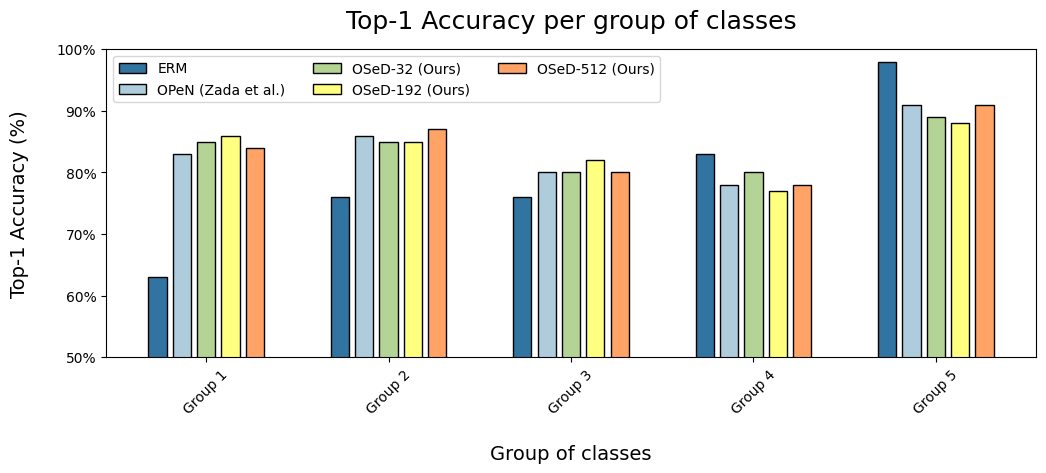

In [19]:
# Top-1 Accuracy per group of classes
f = plt.figure()
X_axis = np.arange(5)*3
plt.xticks(X_axis, ["Group {}".format(i+1) for i in range(5)], rotation = 45)
plt.yticks([y for y in [i/10 for i in range(5, 11, 1)]], [str(y)+"%" for y in range(50, 110, 10)])
plt.ylabel("Top-1 Accuracy (%)", fontsize=14, labelpad=20)
plt.xlabel("Group of classes", fontsize=14, labelpad=20)
plt.ylim(0.5, 1)
plt.title("Top-1 Accuracy per group of classes", fontsize=18, pad=15)
plt.bar(X_axis-0.8, [round(x.item(),2) for x in values["acc_per_class"]["ERM"]][::-1], width=0.3, color="#3274a1", ec="k", label = "ERM")
plt.bar(X_axis-0.4, [round(x.item(),2) for x in values["acc_per_class"]["OPeN"]][::-1], width=0.3, color="#aeccdb", ec="k", label = "OPeN (Zada et al.)")
plt.bar(X_axis, [round(x.item(),2) for x in values["acc_per_class"]["OSeD 32"]][::-1], width=0.3, color="#b3d495", ec="k", label = "OSeD-32 (Ours)")
plt.bar(X_axis+0.4, [round(x.item(),2) for x in values["acc_per_class"]["OSeD 192"]][::-1], width=0.3, color="#ffff80", ec="k", label = "OSeD-192 (Ours)")
plt.bar(X_axis+0.8, [round(x.item(),2) for x in values["acc_per_class"]["OSeD 512"]][::-1], width=0.3, color="#ffa366", ec="k", label = "OSeD-512 (Ours)")
plt.legend(ncol = 3)
f.set_figwidth(12)
f.set_figheight(4)

Results show that both the **OPeN** and the **OSeD** methods (in all its three variants) exhibit a **comparable** *overall Top-1 accuracy*, which is much higher than the one achieved by the *vanilla Empirical Risk Minimization method* (training without oversampling).

The **Per group of classes Top-1 accuracy** plot (displaying the accuracy on the five pairs in which the classes are divided according to their size, with Group1 containing the smaller and Group5 containing the larger ones) suggests additional meaningful insights. All the oversampling methods exhibit *worse* performances with respect to the *ERM* method on the larger classes, but *drastically better* accuracy on the smaller ones (which are usually of the *most interest* in the imbalanced classification settings). The **OPeN** and **OSeD** variants present a specular behavior on *Group1* VS *Group5*: while for the larger classes higher accuracy is achieved by having either **pure random noise** (**OPeN**) or **clear prompt visual representation** (**OSeD-512**) images as additional training samples, for the very smaller ones the best result comes from the **OSeD-192** version, in which **Stable Diffusion** outputs (depicting some "visual artifacts") seems to **strike a balance** between the two.

# Conclusions and future work

The analysis provides us with insights on the role played by **pure random gaussian noise** images in the success of the **OPeN** method.

Our results seem to confirm the strong *regularization power* of training on **pure noise**, especially for larger classes, where **OPeN** achieves the same accuracy of **OSeD** with higher quality images. However, for smaller classes (whose correct classification is of key importance), providing **class dependent** images which are not too far from noise, while carrying **class related information** allows to achieve better performances.

If the **input noise** doesn't have to be *purely gaussian*, we can see the **OPeN** method to evolve even further in the future, dropping the fascinating idea of **training on pure noise** to adopt back the more *classical* one of **additive noise**. Noise could be added stochastically in a large amount and in an almost *distruptive* manner on the oversampled training images to produce **far-from-distribution** samples which would still retain a small portion of the original information, in a *fair* and *general* way, without the need to resort to any additional data generating model.

# References

* Zada, S., Benou, I., & Irani, M. (2022). Pure noise to the rescue of insufficient data: Improving imbalanced classification by training on random noise images. In International Conference on Machine Learning (pp. 25817-25833). PMLR. arXiv:2112.08810
* Zagoruyko, S., & Komodakis, N. (2016). Wide residual networks. arXiv preprint arXiv:1605.07146.
* Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. A simple framework for contrastive learning of visual representations. In International conference on machine learning, pp. 1597–1607. PMLR, 2020. arXiv:2002.05709
* DeVries, T., & Taylor, G. W. (2017). Improved regularization of convolutional neural networks with cutout. arXiv:1708.04552.
* Cao, K., Wei, C., Gaidon, A., Arechiga, N., & Ma, T. (2019). Learning imbalanced datasets with label-distribution-aware margin loss. Advances in neural information processing systems. arXiv:1906.07413.
* Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2022). High-resolution image synthesis with latent diffusion models. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 10684-10695). arXiv:2112.10752